## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

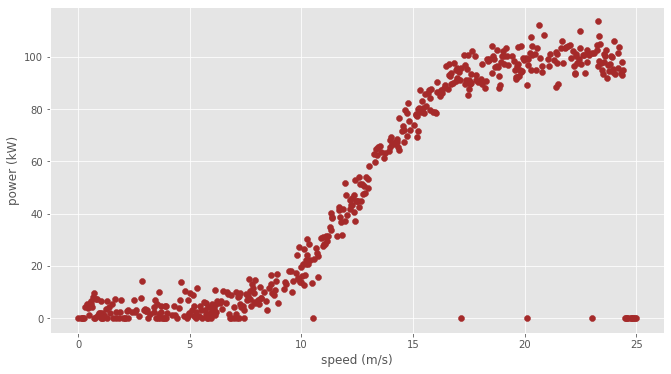

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [6]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Generate instance of the LinearRegression class to create model
reg_pp = LinearRegression()

# Call the fit method to train model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value for evaluation
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of **~0.72**. This represents the R-Squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].

<br>

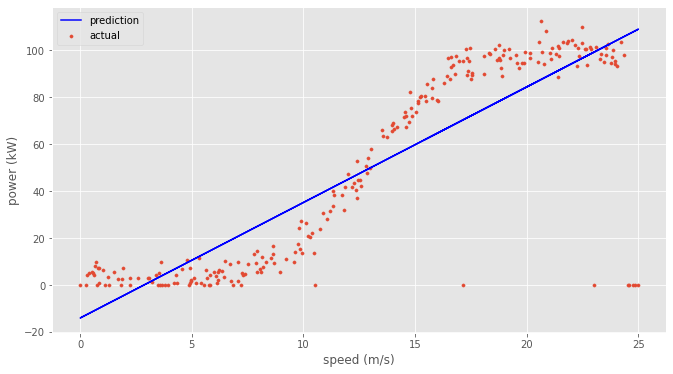

In [7]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

#### 3.1.2 Outlier detection and removal

As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [9]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [10]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [11]:
# Output statistical summary of updated data frame
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

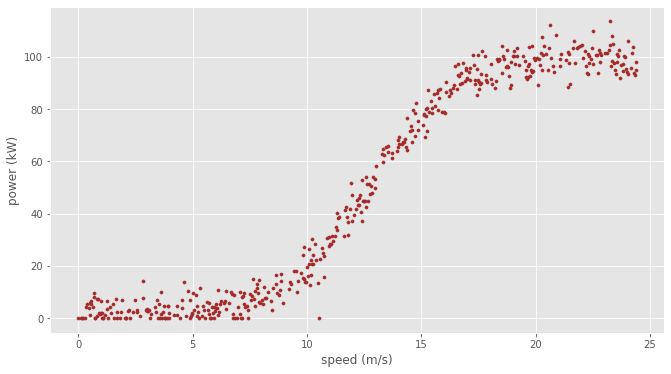

In [12]:
plt.scatter(pp_clean['speed'], pp_clean['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [13]:
pp_zero = pp_clean.loc[pp_clean['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [14]:
pp_updated = pp_clean.drop([208])

Now we can train the model with the updated data set:

In [15]:
# Using original (pp) data set to train model 
speed_df_pp_clean = pp_updated.drop('power',axis='columns')
power_df_pp_clean = pp_updated.drop('speed',axis='columns')

# Train test split
x_train, x_test, y_train, y_test = train_test_split(speed_df_pp_clean, power_df_pp_clean, test_size = 0.5, random_state=1)

# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(x_train, y_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(x_test, y_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of **~0.90**. 

<br>

We can plot both models side by side for visual comparison:

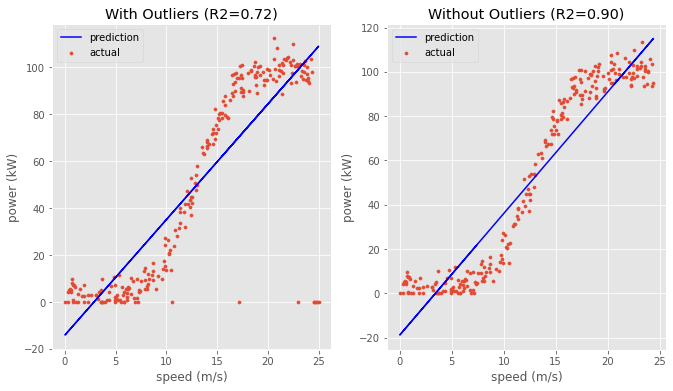

In [16]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(x_test)

plt.scatter(x_test, y_test, label='actual', s=10)
plt.plot(x_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

In machine learning, *evaluation* and *validation* are key aspects in measuring how well a model is performing [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_updated` data set is split by column into two separate subsets, one containing each variable. :

In [17]:
# Create a new dataset containing only values from the speed column
speed_df = pp_updated.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [18]:
# Create a new dataset containing only values from the power column
power_df = pp_updated.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [19]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

In demonstrating the importance of outlier removal above, I used simple linear regression models. This section provides a brief explanation of simple linear regression before exploring polynomial regression to create a predictive model.

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> It can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set. 

Once the outliers were removed, the model as trained on the training data produced a score of ~0.90. For certain predictive models, an R-squared value of ~0.90 might be considered satisfactory. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.


<br>

### 3.3 Polynomial regression

***

Visualising the plots above, we can see that a straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using the `LinearRegression` class just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fitted to the model and predictions are made based on the test data. 

In [45]:
# Convert train and test subsets to numpy arrays
poly_speed_train = x_train.to_numpy().reshape(-1, 1)
poly_power_train = y_train.to_numpy().reshape(-1, 1)
poly_speed_test  = x_test.to_numpy().reshape(-1, 1)
poly_power_test = y_test.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

<br>

Using `sciki-learn`'s evaluation metrics, we can calculate the R-squared value as well as the *mean-squared-error* (mse), which is the most commonly used regression loss function [29]:

In [53]:
# Calculate mean squared error 
mse = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2 = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse, r2_test

(18.29934798625694, 0.9895079443988561)

With an R-Squared value of **~0.99** we can see that polynomial regression performs significantly better than the simple linear regression models above. The mse is **~18.29**. This will be compared with additional models below.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely:

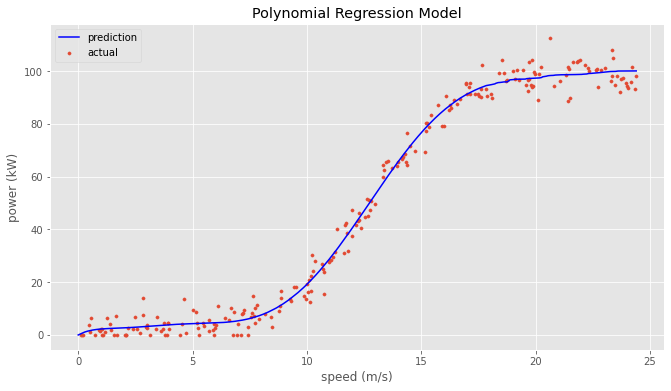

In [55]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.title('Polynomial Regression Model')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

## Neural network - Regression

***

In [ ]:
#pp = pp[pp.power != 0]
#pp.describe()

In [56]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [57]:
model = create_model()

In [ ]:


# msk = np.random.rand(len(pp_clean2)) < 0.5
# train = pp_clean2[msk]

# test = pp_clean2[~msk]

In [ ]:
# model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

In [ ]:
# shapes = model.predict(test['speed'])

In [ ]:
# shapes.shape

In [ ]:
# plt.scatter(test['speed'], test['power'], label='actual', s=10)
# plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
# plt.legend()

In [58]:
model.fit(x_train, y_train, epochs=500, batch_size=10)

Epoch 1/500
25/25 [==============================] - 1s 1ms/step - loss: 3524.5365
Epoch 2/500
25/25 [==============================] - 0s 923us/step - loss: 2199.7915
Epoch 3/500
25/25 [==============================] - 0s 1ms/step - loss: 751.3761
Epoch 4/500
25/25 [==============================] - 0s 1ms/step - loss: 278.7835
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 280.3074
Epoch 6/500
25/25 [==============================] - 0s 1ms/step - loss: 265.3846
Epoch 7/500
25/25 [==============================] - 0s 1ms/step - loss: 251.0651
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 230.1466
Epoch 9/500
25/25 [==============================] - 0s 1ms/step - loss: 219.5990
Epoch 10/500
25/25 [==============================] - 0s 1ms/step - loss: 190.4931
Epoch 11/500
25/25 [==============================] - 0s 923us/step - loss: 214.4802
Epoch 12/500
25/25 [==============================] - 0s 1ms/step - loss: 195.3703
Epoch 1

25/25 [==============================] - 0s 652us/step - loss: 57.5779
Epoch 99/500
25/25 [==============================] - 0s 1ms/step - loss: 55.5203
Epoch 100/500
25/25 [==============================] - 0s 1ms/step - loss: 60.2130
Epoch 101/500
25/25 [==============================] - 0s 985us/step - loss: 53.8163
Epoch 102/500
25/25 [==============================] - 0s 652us/step - loss: 57.9376
Epoch 103/500
25/25 [==============================] - 0s 1ms/step - loss: 54.5530
Epoch 104/500
25/25 [==============================] - 0s 651us/step - loss: 46.3593
Epoch 105/500
25/25 [==============================] - 0s 922us/step - loss: 51.4794
Epoch 106/500
25/25 [==============================] - 0s 652us/step - loss: 58.2202
Epoch 107/500
25/25 [==============================] - 0s 1ms/step - loss: 56.0733
Epoch 108/500
25/25 [==============================] - 0s 652us/step - loss: 63.2418
Epoch 109/500
25/25 [==============================] - 0s 922us/step - loss: 53.9589
Epo

25/25 [==============================] - 0s 460us/step - loss: 31.6612
Epoch 196/500
25/25 [==============================] - 0s 1ms/step - loss: 27.2917
Epoch 197/500
25/25 [==============================] - ETA: 0s - loss: 67.98 - 0s 651us/step - loss: 36.3945
Epoch 198/500
25/25 [==============================] - 0s 651us/step - loss: 35.7743
Epoch 199/500
25/25 [==============================] - 0s 2ms/step - loss: 27.2278
Epoch 200/500
25/25 [==============================] - 0s 1ms/step - loss: 32.6143
Epoch 201/500
25/25 [==============================] - 0s 1ms/step - loss: 35.0668
Epoch 202/500
25/25 [==============================] - 0s 1ms/step - loss: 27.5693
Epoch 203/500
25/25 [==============================] - 0s 1ms/step - loss: 29.9703
Epoch 204/500
25/25 [==============================] - 0s 1ms/step - loss: 30.0231
Epoch 205/500
25/25 [==============================] - 0s 651us/step - loss: 28.8598
Epoch 206/500
25/25 [==============================] - 0s 1ms/step - 

25/25 [==============================] - 0s 924us/step - loss: 23.3185
Epoch 293/500
25/25 [==============================] - 0s 1ms/step - loss: 19.2485
Epoch 294/500
25/25 [==============================] - 0s 653us/step - loss: 17.4894
Epoch 295/500
25/25 [==============================] - 0s 649us/step - loss: 16.0845
Epoch 296/500
25/25 [==============================] - 0s 923us/step - loss: 18.9464
Epoch 297/500
25/25 [==============================] - 0s 1ms/step - loss: 19.0489
Epoch 298/500
25/25 [==============================] - 0s 1ms/step - loss: 17.0972
Epoch 299/500
25/25 [==============================] - 0s 921us/step - loss: 21.5063
Epoch 300/500
25/25 [==============================] - 0s 1ms/step - loss: 19.1143
Epoch 301/500
25/25 [==============================] - 0s 1ms/step - loss: 21.6658
Epoch 302/500
25/25 [==============================] - 0s 1ms/step - loss: 16.4193
Epoch 303/500
25/25 [==============================] - 0s 652us/step - loss: 21.3026
Epoch 

25/25 [==============================] - 0s 652us/step - loss: 18.0409
Epoch 390/500
25/25 [==============================] - 0s 651us/step - loss: 17.9743
Epoch 391/500
25/25 [==============================] - 0s 1ms/step - loss: 19.4080
Epoch 392/500
25/25 [==============================] - 0s 2ms/step - loss: 18.3606
Epoch 393/500
25/25 [==============================] - 0s 1ms/step - loss: 18.8877
Epoch 394/500
25/25 [==============================] - 0s 650us/step - loss: 14.1826
Epoch 395/500
25/25 [==============================] - 0s 904us/step - loss: 16.9504
Epoch 396/500
25/25 [==============================] - 0s 1ms/step - loss: 13.9079
Epoch 397/500
25/25 [==============================] - 0s 653us/step - loss: 16.3783
Epoch 398/500
25/25 [==============================] - 0s 651us/step - loss: 20.2730
Epoch 399/500
25/25 [==============================] - 0s 923us/step - loss: 16.5687
Epoch 400/500
25/25 [==============================] - 0s 1ms/step - loss: 17.4638
Epoc

Epoch 487/500
25/25 [==============================] - 0s 651us/step - loss: 15.1731
Epoch 488/500
25/25 [==============================] - 0s 648us/step - loss: 20.7593
Epoch 489/500
25/25 [==============================] - 0s 2ms/step - loss: 20.2128
Epoch 490/500
25/25 [==============================] - 0s 1ms/step - loss: 17.1661
Epoch 491/500
25/25 [==============================] - 0s 653us/step - loss: 17.2335
Epoch 492/500
25/25 [==============================] - 0s 924us/step - loss: 17.2569
Epoch 493/500
25/25 [==============================] - 0s 1ms/step - loss: 15.4147
Epoch 494/500
25/25 [==============================] - 0s 1ms/step - loss: 14.0710
Epoch 495/500
25/25 [==============================] - 0s 651us/step - loss: 16.9755
Epoch 496/500
25/25 [==============================] - 0s 1ms/step - loss: 15.3046
Epoch 497/500
25/25 [==============================] - 0s 1ms/step - loss: 14.7689
Epoch 498/500
25/25 [==============================] - 0s 651us/step - loss: 

In [59]:
nn_predict = model.predict(x_test)

nn_predict.shape

(243, 1)

In [60]:
arr_sort = np.sort(nn_predict, axis=0)

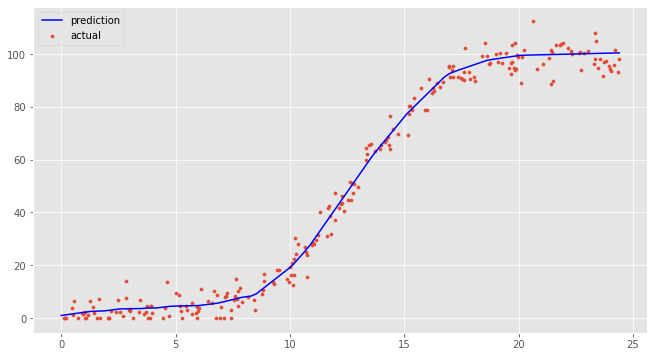

In [61]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(x_test, axis=0)

plt.scatter(x_train, y_train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.save('my_model.h5')

In [ ]:
model.predict([14])

In [66]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4295.5288
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 2086.4090
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 684.6965
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 305.8129
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 157.4590
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 94.9643
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 58.3197
Epoch 8/300
44/44 [==============================] - 0s 2ms/step - loss: 51.2008
Epoch 9/300
44/44 [==============================] - 0s 2ms/step - loss: 42.5466
Epoch 10/300
44/44 [==============================] - 0s 2ms/step - loss: 39.3083
Epoch 11/300
44/44 [==============================] - 0s 2ms/step - loss: 37.9292
Epoch 12/300
44/44 [==============================] - 0s 2ms/step - loss: 33.8682
Epoch 13/300
44/44

44/44 [==============================] - 0s 2ms/step - loss: 18.1478
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1532
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8913
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9340
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4309
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1197
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0829
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7422
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6073
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3231
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4938
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6447
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.6819
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4190
Epoch 200/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5114
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6775
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4295
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3427
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9237
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2486
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1713
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2546
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0479
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5971
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.1685
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9735
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5970
Epoch 299/300
44/44 [==============================] - 0s 3ms/step - loss: 19.6083
Epoch 300/300
5/5 [==============================] - 0s 3ms/step - loss: 7.9915
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3945.1325
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 1862.5505
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 719.8239
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 330.3068
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 168.1926
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 109.2944
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 70.0552
Epoch 8/300
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 18.2242
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3709
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0999
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5744
Epoch 99/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4092
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0305
Epoch 101/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6509
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0589
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5738
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5066
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6684
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5905
Epoch 107/300
44/44 [=

44/44 [==============================] - 0s 3ms/step - loss: 18.0871
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4469
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 20.7519
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2988
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4032
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1079
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6766
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8533
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7204
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2131
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0566
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4075
Epoch 205/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.9484
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1240
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3059
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7066
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3181
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0156
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6226
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5994
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3454
Epoch 300/300
5/5 [==============================] - 0s 3ms/step - loss: 13.0586
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3781.3448
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 1825.8895
Epoch 3/300
44/44 [=

44/44 [==============================] - 0s 2ms/step - loss: 16.8989
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6299
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8664
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0779
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5148
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1985
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0514
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6953
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4403
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8668
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0391
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0727
Epoch 101/300
44/44 [=======

Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5832
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2574
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2932
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1719
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6101
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8218
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5497
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3792
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6155
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9451
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8505
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7117
Epoc

44/44 [==============================] - 0s 2ms/step - loss: 17.9633
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5596
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4249
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6747
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7414
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9672
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4279
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1176
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1774
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7493
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0616
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7465
Epoch 298/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.3238
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5870
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8825
Epoch 88/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3335
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6430
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7969
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5193
Epoch 92/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9010
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5544
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6270
Epoch 95/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7407
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6572
Epoch 97/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 15.5950
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5449
Epoch 186/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6341
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4170
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2072
Epoch 189/300
44/44 [==============================] - 0s 3ms/step - loss: 19.0700
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1843
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1080
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6870
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3886
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5328
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3134
Epoch 196/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.9981
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0591
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8371
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 19.6068
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8970
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1567
Epoch 288/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8714
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7495
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5129
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4911
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2548
Epoch 293/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9458
Epoch 294/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3015
Epoch 82/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7593
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5407
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3736
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6050
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4997
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2198
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9569
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6941
Epoch 90/300
44/44 [==============================] - 0s 3ms/step - loss: 14.2945
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8165
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8177
Epoch 93/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.5640
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2633
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8811
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1301
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8962
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1222
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4268
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8286
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7814
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2073
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4365
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5154
Epoch 192/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.0570
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9683
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3626
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2922
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5708
Epoch 283/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5338
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6758
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3131
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3252
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4264
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0600
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3793
Epoch 290/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.6805
Epoch 78/300
44/44 [==============================] - 0s 3ms/step - loss: 15.4348
Epoch 79/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5021
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3612
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5105
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0404
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8964
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7479
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0328
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3782
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7566
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1559
Epoch 89/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.8109
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0523
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4832
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7052
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7120
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2349
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4392
Epoch 182/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4950
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4435
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6244
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2678
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1574
Epoch 187/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.0968
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2012
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8642
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4479
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2497
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8697
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5223
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0167
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9030
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1003
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6856
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8347
Epoch 285/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7797
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8186
Epoch 73/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0085
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 20.8144
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3195
Epoch 76/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0372
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4006
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3306
Epoch 79/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2599
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8487
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1771
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0163
Epoch 83/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 18.2953
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5472
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2252
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0401
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4659
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8943
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7847
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4512
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7502
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2094
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3779
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1952
Epoch 182/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.0000
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9256
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6925
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8926
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1350
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1312
Epoch 274/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1962
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0723
Epoch 276/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9291
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5586
Epoch 278/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1011
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3770
Epoch 280/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 14.8657
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7421
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0216
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7141
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4766
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0457
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3434
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0055
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7349
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2903
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9960
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9629
Epoch 78/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.5331
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0862
Epoch 167/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0751
Epoch 168/300
44/44 [==============================] - 0s 3ms/step - loss: 15.2304
Epoch 169/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7060
Epoch 170/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5947
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7009
Epoch 172/300
44/44 [==============================] - 0s 3ms/step - loss: 14.2081
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8306
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1449
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3665
Epoch 176/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1101
Epoch 177/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.8703
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2538
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5356
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9225
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7257
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7547
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1801
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6439
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7392
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0408
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4195
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3952
Epoch 275/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.9257
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5849
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4184
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6380
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5864
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9298
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4846
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3803
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0041
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9461
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6610
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0708
Epoch 73/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 17.2739
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0585
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2366
Epoch 163/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3850
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5855
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7176
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8554
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3408
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4464
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4644
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0763
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8658
Epoch 172/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.1790
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5821
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0462
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4214
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4722
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0236
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3651
Epoch 265/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7744
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8549
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6709
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0377
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9184
Epoch 270/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.7157
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3450
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9819
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5704
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4991
Epoch 61/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7810
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3831
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8704
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9448
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9933
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0717
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6008
Epoch 68/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.3401
Epoch 156/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5834
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9963
Epoch 158/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4831
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0404
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9584
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9218
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9416
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2425
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2495
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7385
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0995
Epoch 167/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.3784
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9993
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6630
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 14.2641
Epoch 257/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6215
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0914
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9801
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2092
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7913
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7651
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4479
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8031
Epoch 265/300
44/4

In [ ]:
# 1 layer, sigmoid, 200 epochs, lr=0.01
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

In [ ]:
# 1 layer, sigmoid, 100 epochs, lr=0.01
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [67]:
# 1 layer, sigmoid, 300 epochs, lr=0.01 - 16.98
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -16.98 (5.00) MSE


In [65]:
# 1 layer, sigmoid, 300 epochs, lr=0.001- 17.35
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -17.35 (4.61) MSE


In [ ]:
len(X)

In [ ]:
ep_100 = 25
ep_500_10 = 23.87

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>
[29] Grove, P; 5 Regression Loss Functions All Machine Learners Should Know; https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 <br>